## Simulating a general spacecraft motion where a control torque "u" is being applied.
### The initial parameters: 
The principal inertias of the spacecraft are as follows: $ I_1 = 100 kg m^2 $ $ I_2 = 75 kg m^2 $ $ I_3 = 80 kg m^2 $. The coordinate system of choice for the spacecrafts attitude description are the modified rodrigues parameters (MRPs). The initial attitude coordinates are given by: $\sigma_{B/N}(t_0) = (0.1, 0.2, -0.1)$ (Body Frame w.r.t Inertial) and the initial inertial angular velocities are given by: $\omega_{B/N}(t_0) = (30, 10, -20)$ deg/sec.

The globally asymptotically stabilizing solution is given by:

$u = -K\sigma_{B/R} - [P]\omega_{B/R} + [I](\dot{\omega}_{R/N} - \omega_{B/N} \times \omega_{R/N}) + [\tilde{\omega_{B/N}}][I]\omega_{B/N} - L$

- $-K$: Gain control of 5Nm.
- $\sigma_{B/R}$: MRP coords of the body relative to the reference frame. $[BR] = [BN][RN]^T$.
- $[P]$: 10 Nms where $[P] = P[I_{3x3}]$.
- $[I]$: Diagonal Inertia matrix where $[I] = I[I_{3x3}]$.
- $\dot{\omega}_{R/N}$: Angular acceleration of the reference relative to the inertial frame. 
- $\omega_{B/N}$: Anglular velocity of the body relative to the inertial frame.
- $\omega_{R/N}$: Angular velocity of the reference relative to the inertial frame.
- $L$: External torques. 

In [706]:
from scipy.spatial.transform import Rotation
import numpy as np
import matplotlib.pyplot as plt

In [1782]:
#MRP arguments reformatted for the w_R/N and w_R/N_dot functions.
#sig = np.array([np.sin, np.cos, np.sin])

#Initial Conditions.
w = np.array([np.deg2rad(i) for i in [30, 10, -20]]).T
MRP = np.array([0.1, 0.2, -0.1]).T
K = 5
P = 10 * np.eye(3) #np.array([22.3607, 19.3649, 20.000]) * np.eye(3) 
I = np.array([[100,  0,  0],
              [  0, 75,  0],
              [  0,  0, 80]])

K_I = 0.005

#External Torques.
L = np.array([0, 0, 0])

#Unmodeled Torques.
dL = np.array([0, 0, 0]) #np.array([0.5, -0.3, 0.2]) 


In order to construct the control solution **u**; MRP to DCM and DCM to MRP functions need to be implmented to map bewteen the various frames (for example: $[BR] = [BN][RN]^T$). 

In [1783]:
#Skew Symmetric matrix generator for cross product operations.
def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])

#Mapping functions from MRP coords to their corresponding DCMs and vice versa.
def MRP_to_DCM(a):
    a_norm = np.linalg.norm(a)
    return np.eye(3) + (1/(1 + a_norm**2))**2 * ((8 * np.dot(skew(a),skew(a))) - 4 * (1 - a_norm**2) * skew(a))

def DCM_to_MRP(C):
    z = np.sqrt(C.trace() + 1)
    return (1/(z*(z+2))) * np.array([C[1][2] - C[2][1],
                                     C[2][0] - C[0][2],
                                     C[0][1] - C[1][0]])

#MRP shadow set for circumstances in which │sigma│ > 1.
def MRP_Shadow(sig):
    N = np.linalg.norm(sig)**2
    return np.array([-i/N for i in sig])


A regulator case was simulated in which the refernce frame $R$ is equivalent to the inertial frame $N$ thus $\sigma_{R/N} = 0$. An attitude tracking case was then simulated in which: $\sigma_{R/N} = [0.2sin(ft), 0.3cos(ft), -0.3sin(ft)]$ where $f = 0.05$ rads/sec.

In [1784]:
def MRP_RN(t):
    
    #Regulator case:
    if regulator == True:
         return np.array([0, 0, 0])
    
    f = 0.05
    #Tracking case:
    sig_RN = np.array([0.2 * np.sin(f * t), 0.3 * np.cos(f * t), -0.3 * np.sin(f * t)])
    return sig_RN

In [1785]:
#MRP EOM expressed in terms of omega (i.e: w = 4*[MRP]^-1*sigma_dot).
def MRP_EOM(sig):
    
    q_1 = sig[0]
    q_2 = sig[1]
    q_3 = sig[2]
    
    norm = (np.dot(sig,sig)/np.sqrt(np.dot(sig,sig)))
    
    Q = np.array([[1 - norm**2 + 2 * q_1**2, 2 * (q_1 * q_2 - q_3), 2 * (q_1 * q_3 + q_2)],
                  [2 * (q_1 * q_2 + q_3), 1 - norm**2 + 2 * q_2**2, 2 * (q_2 * q_3 - q_1)],
                  [2 * (q_1 * q_3 - q_2), 2 * (q_2 * q_3 + q_1), 1 - norm**2 + 2 * q_3**2]] , dtype = np.float64)
    
    return Q

def MRP_dot(sig, w):
    q_1, q_2, q_3 = sig
    
    norm = (np.dot(sig,sig)/np.sqrt(np.dot(sig,sig)))
    
    Q = np.array([[1 - norm**2 + 2 * q_1**2, 2 * (q_1 * q_2 - q_3), 2 * (q_1 * q_3 + q_2)],
                  [2 * (q_1 * q_2 + q_3), 1 - norm**2 + 2 * q_2**2, 2 * (q_2 * q_3 - q_1)],
                  [2 * (q_1 * q_3 - q_2), 2 * (q_2 * q_3 + q_1), 1 - norm**2 + 2 * q_3**2]] , dtype = np.float64)
    
    dQdt = np.dot(Q, w)*1/4
    
    return dQdt
    
#Time derivative of the MRP attitude descriptions regarding R/N. Implemented via a first order-
#central difference method.

def w_RN(i, t, sig, h=dt):
    
    f = 0.05
    
    #Regulator Case:
    if regulator == True:
        return np.array([0, 0, 0])
    
    Q = MRP_EOM(MRP_RN(t))
    
    
    #Accounting for 0th interval in the FDM function.
    if i == 0:
        if t == 0:
            sig_dot = [0.2 * f * np.cos(f * t),
                      -0.3 * f * np.sin(f * t),
                      -0.3 * f * np.cos(f * t)]
            
            return 4 * np.dot(np.linalg.inv(Q), sig_dot)
        
    #Tracking case:
    x1 = sig[0]
    x2 = sig[1]
    x3 = sig[2]
    
    x1_dot = (x1[i+1] - x1[i-1]) /(2*h)
    x2_dot = (x2[i+1] - x2[i-1]) /(2*h)
    x3_dot = (x3[i+1] - x3[i-1]) /(2*h)
              
    Sig_dot = np.array([x1_dot, x2_dot, x3_dot])
    
    w = 4 * np.dot(np.linalg.inv(Q), Sig_dot)
    
    return w


#Angular acceleration of the MRP attitude descriptions regarding R/N. Implemented via second order-
#central difference method.
def w_RN_dot(i, t, sig, h=dt):
    
    if regulator == True:

        return np.array([0, 0, 0])

    w1 = w_RN(i, t, sig)
    w2 = w_RN((i + 1), (t + h), sig)

    w_dot = np.subtract(np.array(w2), np.array(w1))/h
    
    return w_dot 
    

In [1786]:
def Trapezoid(i, dt):
    return (error_list[i] + error_list[i-1]) * 1/2 * dt

The asymptotically stabilizing control solution: $$u = -K\sigma_{B/R} - [P]\omega_{B/R} + [I](\dot{\omega}_{R/N} - \omega_{B/N} \times \omega_{R/N}) + [\tilde{\omega_{B/N}}][I]\omega_{B/N} - L$$

The Control EOM: 
$$[I]\dot{\omega}_{B/N} = [\tilde{\omega_{B/N}}][I]\omega_{B/N} + u + L$$

In [1787]:
def Stabilizing_Control(index, time, sig, w, I, sigma, L):
    sig_RN = MRP_RN(time)
    sig_BR = DCM_to_MRP(np.dot(MRP_to_DCM(sig), (MRP_to_DCM(sig_RN)).T))
    omega_RN = w_RN(index, time, sigma)
    omega_RN_dot = w_RN_dot(index, time, sigma)
    DCM_BR = MRP_to_DCM(sig_BR)
    omega_RN_B = np.dot(DCM_BR, omega_RN)
    omega_RN_B_dot = np.dot(DCM_BR, omega_RN_dot)
    omega_BR = w - omega_RN_B
    return -K * sig_BR - np.dot(P, omega_BR) + np.dot(I, omega_RN_B_dot - np.dot(skew(w), omega_RN_B)) + np.cross(w, np.dot(I,w)) - L


#Control EOM expressed in terms of omega dot.
def Control_EOM(index, time, sig, w, I, sigma, L, dL):
    u = Stabilizing_Control(index, time, sig, w, I, sigma, L)
    return np.dot(np.linalg.inv(I), (-np.cross(w, np.dot(I, w)) + u + L + dL))

The Simplified asymptotically stabilizing control solution: $$u = -K\sigma_{B/R} - [P]\omega_{B/R}  - L$$

In [1596]:
def Simplified_Stabilizing_Control(index, time, sig, w, I, sigma, L):
    sig_RN = MRP_RN(time)
    sig_BR = DCM_to_MRP(np.dot(MRP_to_DCM(sig), (MRP_to_DCM(sig_RN)).T))
    omega_RN = w_RN(index, time, sigma)
    omega_RN_dot = w_RN_dot(index, time, sigma)
    DCM_BR = MRP_to_DCM(sig_BR)
    omega_RN_B = np.dot(DCM_BR, omega_RN)
    omega_RN_B_dot = np.dot(DCM_BR, omega_RN_dot)
    omega_BR = w - omega_RN_B
    return -K * sig_BR - np.dot(P, omega_BR) - L


#Control EOM expressed in terms of omega dot.
def Simplified_Control_EOM(index, time, sig, w, I, sigma, L, dL):
    u = Simplified_Stabilizing_Control(index, time, sig, w, I, sigma, L)
    return np.dot(np.linalg.inv(I), (-np.cross(w, np.dot(I, w)) + u + L + dL))

##### Timestep simulation. 
The regulator case is simulated for 120s and the norm $\sqrt{\sigma_1^2 + \sigma_2^2 + \sigma_3^2}$ is computed at 30s. Similarly, the tracking case is simulated for 120s and the MRP tracking error norm $│\sigma_{B/R}│$ is computed at 40s.

For each case, the $\sigma_{B/N}(t)$, $\sigma_{R/N}(t)$ (tracking case), $\omega_{B/N}(t)$, $\omega_{R/N}(t)$ (tracking case) values and their corresponding norms and errors are computed.

###### Regulator Case: 
regulator = True.
###### Tracking Case: 
regulator = False.

In [1794]:
def Timestep(a, b, h, w, MRP, I, L, dL, control_case):
    
    
    #Parameters:
    
    N = int((b-a)/h + 1)
    t = np.linspace(a, b, N)
    dt = int(b-a)/N

    
    #Initialising empty lists:
    
    #sigma_R/N
    sigma = MRP_RN(t)
    #omega_B/N 
    w_list = [w]
    #Sigma_B/N 
    MRP_list = [MRP]
    #Sigma_R/N i.e: This is the target attitude.
    target_list = [MRP_RN(0)]
    #omega_R/N i.e: This is the target attitude rate (angular vel).
    w_RN_list = [w_RN(0, 0, sigma)] 
    #Discrepancy between body and ref.
    error_list = [DCM_to_MRP(np.dot(MRP_to_DCM(MRP), MRP_to_DCM((MRP_RN(0)).T)))]
    #omega diff.
    d_w = []
    
    
    """The time-step loop iterated over 'b-a' seconds. """
    
    trap = Trapezoid(0, dt)
    trap_list = []
    
    for index, time in enumerate(t[1:-2], start=1):
        #Target MRP Coordinates.    
        sig_RN = MRP_RN(time)
        target_list.append(sig_RN)
        #Corresponding MRP coordinate errors.
        sig_BR = DCM_to_MRP(np.dot(MRP_to_DCM(MRP), (MRP_to_DCM(sig_RN)).T))
        error_list.append(sig_BR)
        #Rates of ref relative to inertial.
        omega_RN = w_RN(index, time, sigma)
        w_RN_list.append(omega_RN)
        #Acceleration of ref relative to inertial.
        omega_RN_dot = w_RN_dot(index, time, sigma)
        w_BR = w - omega_RN
    
        MRP = MRP + MRP_dot(MRP, w) * dt
        
    
        """
           The control case parameters:
           0: The asymptotically stabilizing control law outlined above.
           1: R/N -> Stationary, u is linear in sigma_B/N, omega_B/N resulting in a simplified control law.
           2: The asymptotically stabilizing control law with integral control feedback.
           3: Saturated control law. Lyapunov Optimal Control.
           4: Linear Closed Loop Control.
        """
        
        if control_case == 0:
            w = w + Control_EOM(index, time, MRP, w, I, sigma, L, dL) * dt
        elif control_case == 1:
            w = w + Simplified_Control_EOM(index, time, MRP, w, I, sigma, L, dL) * dt
        elif control_case == 2:
            w = w + Integral_Control_EOM(index, time, MRP, w, I, sigma, L, dL, trap) * dt
        elif control_case == 3:
            w = w + Optimal_Control_EOM(index, time, MRP, w, I, sigma, L, dL) * dt
        elif control_case == 4:
            w = w + Linear_Closed_Loop_Control_EOM(index, time, MRP, w, I, sigma, L, dL) * dt
 
        if np.dot(MRP, MRP) > 1:
            MRP = MRP_Shadow(MRP)
        
        MRP_list.append(MRP)

        w_list.append(w)
        
        trap += Trapezoid(index, dt) 
        trap_list.append(trap)
    
        if time % 30 == 0:
            print("Simulated {} seconds".format(time))
        
    return np.array(MRP_list), np.array(w_list), np.array(target_list), np.array(w_RN_list), np.array(w_RN_dot_list), np.array(error_list)

# MRP_list = np.array(MRP_list)    
# w_list = np.array(w_list)
# target_list = np.array(target_list)
# w_RN_list = np.array(w_RN_list)
# w_RN_dot_list = np.array(w_RN_dot_list)
# error_list = np.array(error_list)

In [1797]:
a = 0; b = 122; N = int((b-a)/h + 1); t = np.linspace(a, b, N)

### The Regulator Case:

In [1795]:
regulator = True
Regulator_Case = Timestep(0, 122, 0.01, w, MRP, I, L, dL, 0)

Simulated 30.0 seconds
Simulated 60.0 seconds
Simulated 90.0 seconds
Simulated 120.0 seconds


The regulator case norm $\sqrt{\sigma_1^2 + \sigma_2^2 + \sigma_3^2}$ computed at 30s:

In [1599]:
#Ensure regulator = True.
MRP_norm_reg = [np.dot(i, i) for i in Regulator_Case[0]]
print("Norm at ", t[3000], "s: ", np.sqrt(MRP_norm_reg[3000]))

Norm at  30.0 s:  0.19475063834006312


The MRP tracking error norm $│\sigma_{B/R}│$ computed at 40s:

In [1798]:
error_norm_reg = [np.sqrt(i**2 + j**2 + k**2) for i, j, k in Regulator_Case[5]]
print("Norm Sigma_BR at ", t[4000], "s: ", error_norm_reg[4000])

Norm Sigma_BR at  40.0 s:  0.1141349647264661


#### Plotting The Attitude Developments vs Target Attitudes:

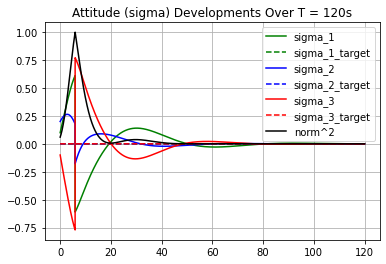

In [1602]:
a = 0; b = 122; h = 0.01; N = int((b-a)/h + 1)
t_plot = np.linspace(a, b-2, N-2)

plt.plot(t_plot, Regulator_Case[0][:, 0], 'g')
plt.plot(t_plot, Regulator_Case[2][:, 0], 'g--')
plt.plot(t_plot, Regulator_Case[0][:, 1], 'b')
plt.plot(t_plot, Regulator_Case[2][:, 1], 'b--')
plt.plot(t_plot, Regulator_Case[0][:, 2], 'r')
plt.plot(t_plot, Regulator_Case[2][:, 2], 'r--')
plt.plot(t_plot, MRP_norm_reg, 'k')
plt.title('Attitude (sigma) Developments Over T = 120s')
plt.legend(["sigma_1", "sigma_1_target", "sigma_2", "sigma_2_target", "sigma_3", "sigma_3_target", "norm^2"], loc='upper right')
plt.grid()

#### Plotting The Attitude Rates vs Target Attitude Rates:

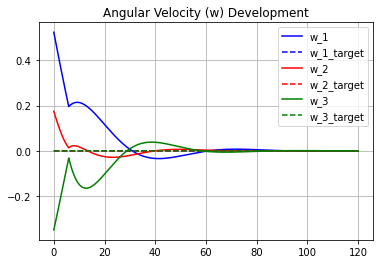

In [1604]:
a = 0; b = 122; h = 0.01; N = int((b-a)/h + 1)
t_plot = np.linspace(a, b-2, N-2)

plt.plot(t_plot, Regulator_Case[1][:, 0], 'b')
plt.plot(t_plot, Regulator_Case[3][:, 0], 'b--')
plt.plot(t_plot, Regulator_Case[1][:, 1], 'r')
plt.plot(t_plot, Regulator_Case[3][:, 1], 'r--')
plt.plot(t_plot, Regulator_Case[1][:, 2], 'g')
plt.plot(t_plot, Regulator_Case[3][:, 2], 'g--')
plt.title("Angular Velocity (w) Development")
plt.legend(["w_1", "w_1_target", "w_2", "w_2_target", "w_3", "w_3_target"])
plt.grid()

### The Tracking Case:

In [1605]:
regulator = False
Tracking_Case = Timestep(0, 122, 0.01, w, MRP, I, L, dL, 0)

Simulated 30.0 seconds
Simulated 60.0 seconds
Simulated 90.0 seconds
Simulated 120.0 seconds


The regulator case norm $\sqrt{\sigma_1^2 + \sigma_2^2 + \sigma_3^2}$ computed at 30s:

In [1606]:
#Ensure regulator = False.
MRP_norm_track = [np.dot(i, i) for i in Tracking_Case[0]]
print("Norm at ", t[3000], "s: ", np.sqrt(MRP_norm_track[3000]))

Norm at  30.0 s:  0.309874233133459


The MRP tracking error norm $│\sigma_{B/R}│$ computed at 40s:

In [1607]:
#Ensure regulator = False.
error_norm_track = [np.sqrt(i**2 + j**2 + k**2) for i, j, k in Tracking_Case[5]]
print("Norm Sigma_BR at ", t[4000], "s: ", error_norm_track[4000])

Norm Sigma_BR at  40.0 s:  0.15879099927841514


#### Plotting The Attitude Developments vs Target Attitudes:

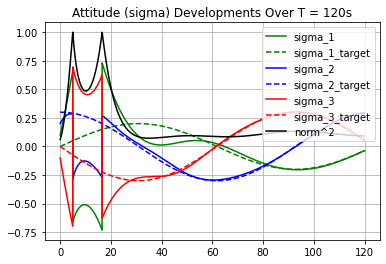

In [1608]:
a = 0; b = 122; h = 0.01; N = int((b-a)/h + 1)
t_plot = np.linspace(a, b-2, N-2)

plt.plot(t_plot, Tracking_Case[0][:, 0], 'g')
plt.plot(t_plot, Tracking_Case[2][:, 0], 'g--')
plt.plot(t_plot, Tracking_Case[0][:, 1], 'b')
plt.plot(t_plot, Tracking_Case[2][:, 1], 'b--')
plt.plot(t_plot, Tracking_Case[0][:, 2], 'r')
plt.plot(t_plot, Tracking_Case[2][:, 2], 'r--')
plt.plot(t_plot, MRP_norm_track, 'k')
plt.title('Attitude (sigma) Developments Over T = 120s')
plt.legend(["sigma_1", "sigma_1_target", "sigma_2", "sigma_2_target", "sigma_3", "sigma_3_target", "norm^2"], loc='upper right')
plt.grid()

#### Plotting The Attitude Rates vs Target Attitude Rates:

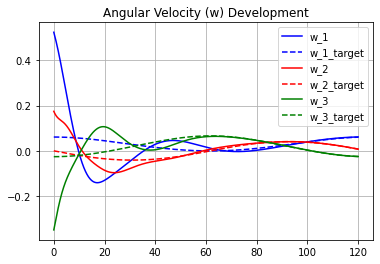

In [1609]:
a = 0; b = 122; h = 0.01; N = int((b-a)/h + 1)
t_plot = np.linspace(a, b-2, N-2)

plt.plot(t_plot, Tracking_Case[1][:, 0], 'b')
plt.plot(t_plot, Tracking_Case[3][:, 0], 'b--')
plt.plot(t_plot, Tracking_Case[1][:, 1], 'r')
plt.plot(t_plot, Tracking_Case[3][:, 1], 'r--')
plt.plot(t_plot, Tracking_Case[1][:, 2], 'g')
plt.plot(t_plot, Tracking_Case[3][:, 2], 'g--')
plt.title("Angular Velocity (w) Development")
plt.legend(["w_1", "w_1_target", "w_2", "w_2_target", "w_3", "w_3_target"])
plt.grid()

### Incorporating Unmodeled Torques (i.e $\Delta L$):

The Control EOM now takes the form:
$$[I]\dot{\omega}_{B/N} = [\tilde{\omega}_{B/N}][I]\omega_{B/N} + u + L + \Delta L $$

Taking the exact parameters as the example above with the exception of utilisigng only the zero-rotation as the reference and alsoincorporating $\Delta L$ into the control EOM:

Therefore one finds:
$\sigma_{RN} = (0, 0, 0)$,
$\omega_{RN} = (0, 0, 0)$,
$\dot{\omega}_{RN} = (0, 0, 0)$

In [1610]:
regulator = True #i.e: Sigma_R/N, Omega_R/N and Omega_dot_R/N = (0,0,0)
Unmodeled_T_Case = Timestep(0, 122, 0.01, w, MRP, I, L, np.array([0.5, -0.3, 0.2]), 0)

Simulated 30.0 seconds
Simulated 60.0 seconds
Simulated 90.0 seconds
Simulated 120.0 seconds


#### Plotting The Attitude Developments vs Target Attitudes:

In [1611]:
MRP_norm_T = [np.dot(i, i) for i in Tracking_Case[0]]

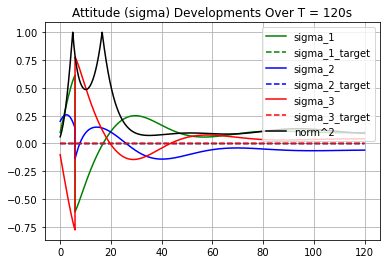

In [1612]:
a = 0; b = 122; h = 0.01; N = int((b-a)/h + 1)
t_plot = np.linspace(a, b-2, N-2)

plt.plot(t_plot, Unmodeled_T_Case[0][:,0], 'g')
plt.plot(t_plot, Unmodeled_T_Case[2][:, 0], 'g--')
plt.plot(t_plot, Unmodeled_T_Case[0][:,1], 'b')
plt.plot(t_plot, Unmodeled_T_Case[2][:, 1], 'b--')
plt.plot(t_plot, Unmodeled_T_Case[0][:,2], 'r')
plt.plot(t_plot, Unmodeled_T_Case[2][:, 2], 'r--')
plt.plot(t_plot, MRP_norm_T, 'k')
plt.title('Attitude (sigma) Developments Over T = 120s')
plt.legend(["sigma_1", "sigma_1_target", "sigma_2", "sigma_2_target", "sigma_3", "sigma_3_target", "norm^2"], loc='upper right')
plt.grid()

#### Plotting The Attitude Rates vs Target Attitude Rates:

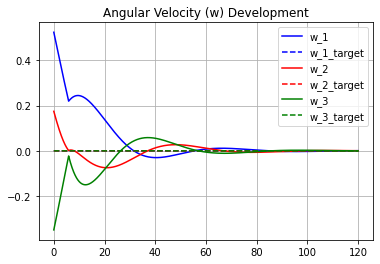

In [1613]:
a = 0; b = 122; h = 0.01; N = int((b-a)/h + 1)
t_plot = np.linspace(a, b-2, N-2)

plt.plot(t_plot, Unmodeled_T_Case[1][:, 0], 'b')
plt.plot(t_plot, Unmodeled_T_Case[3][:, 0], 'b--')
plt.plot(t_plot, Unmodeled_T_Case[1][:, 1], 'r')
plt.plot(t_plot, Unmodeled_T_Case[3][:, 1], 'r--')
plt.plot(t_plot, Unmodeled_T_Case[1][:, 2], 'g')
plt.plot(t_plot, Unmodeled_T_Case[3][:, 2], 'g--')
plt.title("Angular Velocity (w) Development")
plt.legend(["w_1", "w_1_target", "w_2", "w_2_target", "w_3", "w_3_target"])
plt.grid()

Computing the tracking error MRP norm (│$\sigma_{BR}$│) at 35s:

In [1614]:
#Ensure regulator = True AND lists reset etc.
error_norm_T = [np.sqrt(i**2 + j**2 + k**2) for i, j, k in Unmodeled_T_Case[5]]
print("Norm Sigma_BR at ", t[3500], "s: ", error_norm_T[3500])

Norm Sigma_BR at  35.0 s:  0.2768644348378831


Thus, even in the presence of an unmodeled external torque vector dL, the
angular velocity tracking errors will asymptotically decay to zero. However, the attitude tracking errors do not, instead once finds the attitude tracking errors to aproach the steady state attitude error governed by: 

$$\sigma_{ss} = \frac{1}{K} \Delta L $$

### Integral Control Feedback.

$$u = -K\sigma_{BR} - [P]\omega_{BR} + [I](\dot{\omega}_{RN} - \omega{BN} \times \omega_{RN}) + [\tilde{\omega}_{BN}][I]\omega_{BN} - [P]K_Iz$$

where z is the integral feedback component: $$z = K \int{\sigma_{BR}}dt + [I](\delta\omega - \delta\omega_0)$$

In [1408]:
def Integral_Stabilizing_Control(index, time, sig, w, I, sigma, L, trap):
    sig_RN = MRP_RN(time)
    sig_BR = DCM_to_MRP(np.dot(MRP_to_DCM(sig), (MRP_to_DCM(sig_RN)).T))
    omega_RN = w_RN(index, time, sigma)
    omega_RN_dot = w_RN_dot(index, time, sigma)
    DCM_BR = MRP_to_DCM(sig_BR)
    omega_RN_B = np.dot(DCM_BR, omega_RN)
    omega_RN_B_dot = np.dot(DCM_BR, omega_RN_dot)
    omega_BR = w - omega_RN_B
    dw = omega_BR - d_w[0]

    z = K * trap + np.dot(I, dw.T)

    u = -K * sig_BR - np.dot(P, omega_BR) + np.dot(I, omega_RN_B_dot - np.dot(skew(w), omega_RN_B)) + np.cross(w, np.dot(I,w)) - np.dot(P*K_I,z) - L
    
    return u


#Control EOM expressed in terms of omega dot.
def Integral_Control_EOM(index, time, sig, w, I, sigma, L, dL, trap):
    u = Integral_Stabilizing_Control(index, time, sig, w, I, sigma, L, trap)
    return np.dot(np.linalg.inv(I), (-np.cross(w, np.dot(I, w)) + u + L + dL))

In [1410]:
regulator = False
Integral_Feedback_Control = Timestep(0, 240, 0.01, w, MRP, I, L, np.array([0.5, -0.3, 0.2]), 2)

Simulated 30.0 seconds
Simulated 60.0 seconds
Simulated 90.0 seconds
Simulated 120.0 seconds
Simulated 150.0 seconds
Simulated 180.0 seconds
Simulated 210.0 seconds


In [1411]:
#Ensure regulator = False AND lists reset etc.
error_norm_Int = [np.sqrt(i**2 + j**2 + k**2) for i, j, k in Integral_Feedback_Control[5]]
print("Norm Sigma_BR at ", t[4500], "s: ", error_norm_Int[4500])

Norm Sigma_BR at  45.0 s:  0.02821115776687765


## Lyapunov Optimal Control Laws

Assume that the available control torque about the ith body axis is limited by
$u_{max_i}$. We augment the unsaturated control law $u_{us}$ with a Lyapunov optimal saturated term to yield a modified control law u_i:

With $u_{us}$ in this case once again being:

$$u = -K\sigma_{B/R} - [P]\omega_{B/R} + [I](\dot{\omega}_{R/N} - \omega_{B/N} \times \omega_{R/N}) + [\tilde{\omega_{B/N}}][I]\omega_{B/N} - L$$

$$ u_i=   \left\{
\begin{array}{ll}
      u_{us_i} & for │u_{us_i}│ \le u_{max_i}\\
      u_{max_i}sgn(u_{us_i}) & for │u_{us_i}│ > u_{max_i}\\
\end{array} 
\right.  $$

In [1657]:
def Optimal_Stabilizing_Control(index, time, sig, w, I, sigma, L):
    sig_RN = MRP_RN(time)
    sig_BR = DCM_to_MRP(np.dot(MRP_to_DCM(sig), (MRP_to_DCM(sig_RN)).T))
    omega_RN = w_RN(index, time, sigma)
    omega_RN_dot = w_RN_dot(index, time, sigma)
    DCM_BR = MRP_to_DCM(sig_BR)
    omega_RN_B = np.dot(DCM_BR, omega_RN)
    omega_RN_B_dot = np.dot(DCM_BR, omega_RN_dot)
    omega_BR = w - omega_RN_B
    
    u =  -K * sig_BR - np.dot(P, omega_BR) + np.dot(I, omega_RN_B_dot - np.dot(skew(w), omega_RN_B)) + np.cross(w, np.dot(I,w)) - L
    
    u_max = 1
    
    return np.array([u_max * np.sign(i) if abs(i) > u_max else i for i in u])

#Control EOM expressed in terms of omega dot.
def Optimal_Control_EOM(index, time, sig, w, I, sigma, L, dL):
    u = Optimal_Stabilizing_Control(index, time, sig, w, I, sigma, L)
    return np.dot(np.linalg.inv(I), (-np.cross(w, np.dot(I, w)) + u + L + dL))


In [1658]:
regulator = False
Lyapunov_Optimal_Control = Timestep(0, 182, 0.01, w, MRP, I, L, dL, 3)

Simulated 30.0 seconds
Simulated 60.0 seconds
Simulated 90.0 seconds
Simulated 120.0 seconds
Simulated 150.0 seconds
Simulated 180.0 seconds


In [1659]:
#Ensure regulator = False AND lists reset etc.
error_norm_Op = [np.sqrt(i**2 + j**2 + k**2) for i, j, k in Lyapunov_Optimal_Control[5]]
print("Norm Sigma_BR at ", t[6000], "s: ", error_norm_Op[6000])

Norm Sigma_BR at  60.0 s:  0.5214699644460484


In [1662]:
MRP_norm_L = [np.dot(i, i) for i in Lyapunov_Optimal_Control[0]]

#### Plotting The Attitude Developments vs Target Attitudes:

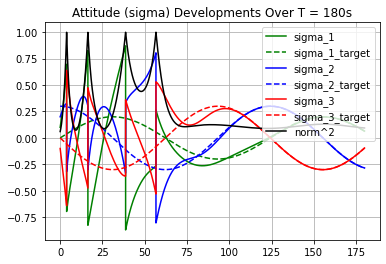

In [1663]:
a = 0; b = 182; h = 0.01; N = int((b-a)/h + 1)
t_plot = np.linspace(a, b-2, N-2)

plt.plot(t_plot, Lyapunov_Optimal_Control[0][:,0], 'g')
plt.plot(t_plot, Lyapunov_Optimal_Control[2][:, 0], 'g--')
plt.plot(t_plot, Lyapunov_Optimal_Control[0][:,1], 'b')
plt.plot(t_plot, Lyapunov_Optimal_Control[2][:, 1], 'b--')
plt.plot(t_plot, Lyapunov_Optimal_Control[0][:,2], 'r')
plt.plot(t_plot, Lyapunov_Optimal_Control[2][:, 2], 'r--')
plt.plot(t_plot, MRP_norm_L, 'k')
plt.title('Attitude (sigma) Developments Over T = 180s')
plt.legend(["sigma_1", "sigma_1_target", "sigma_2", "sigma_2_target", "sigma_3", "sigma_3_target", "norm^2"], loc='upper right')
plt.grid()

#### Plotting The Attitude Rates vs Target Attitude Rates:

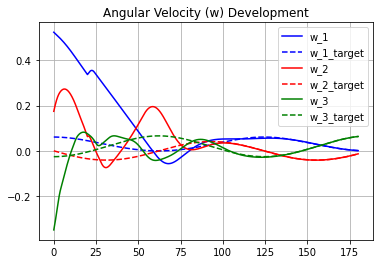

In [1661]:
a = 0; b = 182; h = 0.01; N = int((b-a)/h + 1)
t_plot = np.linspace(a, b-2, N-2)

plt.plot(t_plot, Lyapunov_Optimal_Control[1][:, 0], 'b')
plt.plot(t_plot, Lyapunov_Optimal_Control[3][:, 0], 'b--')
plt.plot(t_plot, Lyapunov_Optimal_Control[1][:, 1], 'r')
plt.plot(t_plot, Lyapunov_Optimal_Control[3][:, 1], 'r--')
plt.plot(t_plot, Lyapunov_Optimal_Control[1][:, 2], 'g')
plt.plot(t_plot, Lyapunov_Optimal_Control[3][:, 2], 'g--')
plt.title("Angular Velocity (w) Development")
plt.legend(["w_1", "w_1_target", "w_2", "w_2_target", "w_3", "w_3_target"])
plt.grid()

### Linearized Closed Loop Dynamics.

The new control law used:

$$u = [\tilde{\omega_{B/N}}][I]\omega_{B/N} + [I]\dot{\omega}_{BN}$$

Where: $$\dot{\omega}_{BN} = -P\omega_{BN} - \big(\omega_{BN}\omega_{BN}^T + \frac{4K}{1 + \sigma^2} - \frac{\omega^2}{2} \big)[I_{3\times 3}] \big)\sigma$$

In [1757]:
def Linear_Closed_Loop_Control(index, time, sig, w, I, sigma, L):
    sig_RN = MRP_RN(time)
    sig_BR = DCM_to_MRP(np.dot(MRP_to_DCM(sig), (MRP_to_DCM(sig_RN)).T))
    omega_RN = w_RN(index, time, sigma)
    omega_RN_dot = w_RN_dot(index, time, sigma)
    DCM_BR = MRP_to_DCM(sig_BR)
    omega_RN_B = np.dot(DCM_BR, omega_RN)
    omega_RN_B_dot = np.dot(DCM_BR, omega_RN_dot)
    omega_BR = w - omega_RN_B
    w_BN_dot = -np.dot(P, w) - (np.dot((np.dot(w, w.T)) + (4*K/(1 + np.linalg.norm(sig)**2) - np.linalg.norm(w)**2/2)*np.eye(3), sig))
    
    return np.dot(skew(w), np.dot(I, w)) + np.dot(I, w_BN_dot)


#Control EOM expressed in terms of omega dot.
def Linear_Closed_Loop_Control_EOM(index, time, sig, w, I, sigma, L, dL):
    u = Linear_Closed_Loop_Control(index, time, sig, w, I, sigma, L)
    return np.dot(np.linalg.inv(I), (-np.cross(w, np.dot(I, w)) + u + L + dL))

In [1800]:
L = np.array([0,0,0]); dL = np.array([0,0,0]); K =0.11; P = 3 * np.eye(3)
regulator = True
LCL_Control = Timestep(0, 122, 0.01, w, MRP, I, L, dL, 4)

Simulated 30.0 seconds
Simulated 60.0 seconds
Simulated 90.0 seconds
Simulated 120.0 seconds


In [1801]:
error_norm_LCL = [np.sqrt(i**2 + j**2 + k**2) for i, j, k in LCL_Control[5]]
print("Norm Sigma_BR at ", t[5000], "s: ", error_norm_LCL[5000])

Norm Sigma_BR at  50.0 s:  0.04629465834696846


#### Plotting The Attitude Developments vs Target Attitudes:

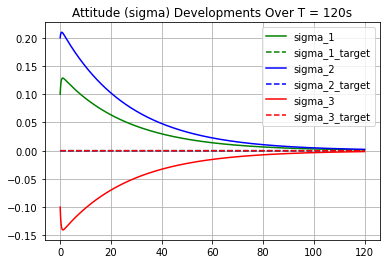

In [1805]:
a = 0; b = 122; h = 0.01; N = int((b-a)/h + 1)
t_plot = np.linspace(a, b-2, N-2)

plt.plot(t_plot, LCL_Control[0][:,0], 'g')
plt.plot(t_plot, LCL_Control[2][:, 0], 'g--')
plt.plot(t_plot, LCL_Control[0][:,1], 'b')
plt.plot(t_plot, LCL_Control[2][:, 1], 'b--')
plt.plot(t_plot, LCL_Control[0][:,2], 'r')
plt.plot(t_plot, LCL_Control[2][:, 2], 'r--')
#plt.plot(t_plot, MRP_norm_L, 'k')
plt.title('Attitude (sigma) Developments Over T = 120s')
plt.legend(["sigma_1", "sigma_1_target", "sigma_2", "sigma_2_target", "sigma_3", "sigma_3_target", "norm^2"], loc='upper right')
plt.grid()

#### Plotting The Attitude Rates vs Target Attitude Rates:

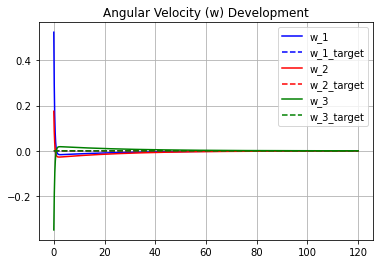

In [1803]:
a = 0; b = 122; h = 0.01; N = int((b-a)/h + 1)
t_plot = np.linspace(a, b-2, N-2)

plt.plot(t_plot, LCL_Control[1][:, 0], 'b')
plt.plot(t_plot, LCL_Control[3][:, 0], 'b--')
plt.plot(t_plot, LCL_Control[1][:, 1], 'r')
plt.plot(t_plot, LCL_Control[3][:, 1], 'r--')
plt.plot(t_plot, LCL_Control[1][:, 2], 'g')
plt.plot(t_plot, LCL_Control[3][:, 2], 'g--')
plt.title("Angular Velocity (w) Development")
plt.legend(["w_1", "w_1_target", "w_2", "w_2_target", "w_3", "w_3_target"])
plt.grid()